## 詐欺隨機森林模型
1. 不處理資料不平衡分佈
2. 超參數調教
3. 計算效能指標
4. ROC_AUC Curve
5. factor importance
6. confusion matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

In [2]:
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False

### 資料讀取

In [3]:
df = pd.read_csv("../data/trainFRAUD.csv", encoding="utf8")

In [4]:
df.head()

,性別,教育,神智,年齡,每月採尿平均,實際保管長度,違規次數,獎勵次數,犯次,一年內次數,二年內次數,三年內次數,四年內次數,五年內次數,首犯年齡,再犯註記
0,1,1,0,4,0.0,1,0,0,4,0,0,0,1,0,0,0
1,1,2,0,4,0.0,6,0,1,2,0,0,0,0,0,2,0
2,1,2,0,4,0.0,6,0,1,2,0,0,0,0,0,2,0
3,1,2,1,4,0.0,5,0,0,2,0,1,0,0,0,1,0
4,1,1,0,3,0.0,1,0,1,4,0,0,0,0,2,1,0


In [5]:
df.columns

Index(['性別', '教育', '神智', '年齡', '每月採尿平均', '實際保管長度', '違規次數', '獎勵次數', '犯次',
       '一年內次數', '二年內次數', '三年內次數', '四年內次數', '五年內次數', '首犯年齡', '再犯註記'],
      dtype='object')

In [6]:
df.shape

(14199, 16)

Text(0.5, 0, '再犯註記(1:再犯，0:非再犯)')

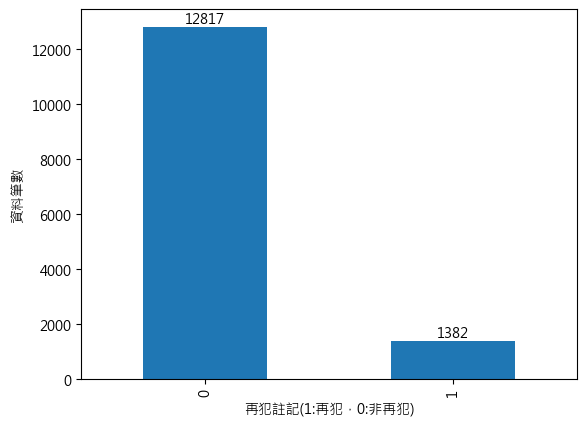

In [7]:
tgtn = df.groupby('再犯註記')
ax = tgtn.size().plot.bar()
ax.bar_label(ax.containers[0]) #顯示bar的資料數據 
ax.set_ylabel("資料筆數") #設定y軸標籤
ax.set_xlabel("再犯註記(1:再犯，0:非再犯)") #設定y軸標籤

### 建立訓練集與測試集(X, y)

In [8]:
X = df.drop(labels=['再犯註記'], axis=1).values
y = df['再犯註記'].values

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
target_names = ['非再犯','再犯']

In [11]:
# 基本模型/原始資料
model1 = RandomForestClassifier(random_state=42, n_jobs=-1)
model1.fit(train_X, train_y)
y_pred = model1.predict_proba(test_X)[:, 1]
predict_y = model1.predict(test_X)
fpr1, tpr1, _ = roc_curve(test_y, y_pred)
auc1 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.92      0.98      0.95      2554
          再犯       0.55      0.20      0.30       286

    accuracy                           0.90      2840
   macro avg       0.73      0.59      0.62      2840
weighted avg       0.88      0.90      0.88      2840



In [12]:
# RF model with balanced class weight
model2 = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
model2.fit(train_X, train_y)
y_pred = model2.predict_proba(test_X)[:, 1]
predict_y = model2.predict(test_X)
fpr2, tpr2, _ = roc_curve(test_y, y_pred)
auc2 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.92      0.95      0.94      2554
          再犯       0.39      0.26      0.31       286

    accuracy                           0.88      2840
   macro avg       0.65      0.61      0.62      2840
weighted avg       0.87      0.88      0.87      2840



In [13]:
# RF model with balanced subsample class weight
model3 = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1)
model3.fit(train_X, train_y)
y_pred = model3.predict_proba(test_X)[:, 1]
predict_y = model3.predict(test_X)
fpr3, tpr3, _ = roc_curve(test_y, y_pred)
auc3 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.92      0.95      0.94      2554
          再犯       0.39      0.27      0.32       286

    accuracy                           0.88      2840
   macro avg       0.66      0.61      0.63      2840
weighted avg       0.87      0.88      0.87      2840



In [14]:
# RF with SMOTE
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(train_X, train_y) #X, y
model4 = RandomForestClassifier(random_state=42, n_jobs=-1)
model4.fit(X_over, y_over)
y_pred = model4.predict_proba(test_X)[:, 1]
predict_y = model4.predict(test_X)
fpr4, tpr4, _ = roc_curve(test_y, y_pred)
auc4 = round(roc_auc_score(test_y, y_pred), 4)
print(classification_report(test_y, predict_y, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.92      0.95      0.94      2554
          再犯       0.38      0.27      0.31       286

    accuracy                           0.88      2840
   macro avg       0.65      0.61      0.62      2840
weighted avg       0.87      0.88      0.87      2840



Text(0, 0.5, 'tpr')

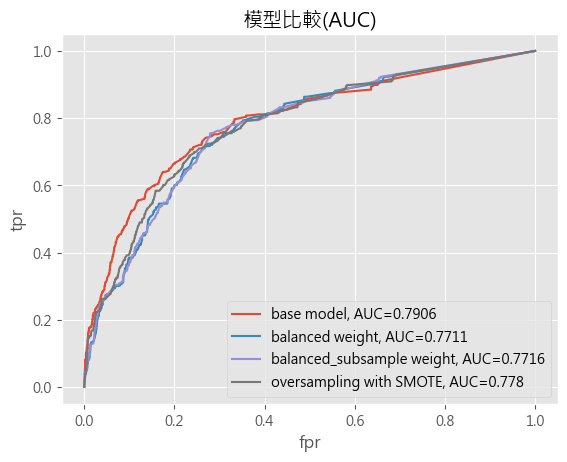

In [15]:
# plot ROC_AUC graph
plt.figure(0).clf()
plt.style.use("ggplot")

plt.plot(fpr1,tpr1,label="base model, AUC="+str(auc1))
plt.plot(fpr2,tpr2,label="balanced weight, AUC="+str(auc2))
plt.plot(fpr3,tpr3,label="balanced_subsample weight, AUC="+str(auc3))
plt.plot(fpr4,tpr4,label="oversampling with SMOTE, AUC="+str(auc4))

plt.legend(loc=0)
plt.title("模型比較(AUC)")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.savefig("fraud_auc.png")